## 车道线检测项目

具体实现步骤：


* 计算摄像机的校准矩阵与畸变系数（借助已有的黑白棋盘图像）
* 对原始图像应用失真校正
* 应用颜色转换，梯度等手段对图像处理得到一个阈值化的二进制图像
* 应用透视变化技术将二进制图像转换视角得到鸟瞰视角图（"birds-eye view"）
* 检测二进制图像的车道像素并进行拟合以找到车道边界
* 确定计算得到车道的曲率
* 将检测到的车道边界与回原始图像叠加
* 可视化显示车道边界以及车道曲率

---
### 第一步：计算图片失真矫正参数（借助棋盘图像）

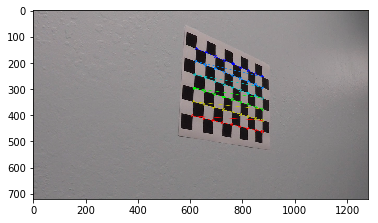

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# 创建空list用于存储来自所有图像的实际点和图像点
objpoints = [] # 3D点称为object points，真实世界的坐标
imgpoints = [] # 2D图像点称为image points

# 得到camera_cal文件夹下图片的路径+文件名，存储到list
images = glob.glob('camera_cal/calibration*.jpg')

# 对camera_cal文件夹下图片逐个处理得到corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # 找到棋盘的corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    #如果找到corners,将实际点和图像点添加到list中
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# 显示corners
img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
plt.imshow(img)


### 第二步：对图片进行失真矫正

In [2]:
def cal_undistort(img, objpoints, imgpoints):
    
    # 这里用到了cv2.calibrateCamera() and cv2.undistort()
    
    img = np.copy(img)  
    img_size = (img.shape[1], img.shape[0]) 
    
    # 根据已经获得的的objpoints, imgpoints进行摄像机标定
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)    
    return undist

Text(0.5, 1.0, 'Undistorted Image')

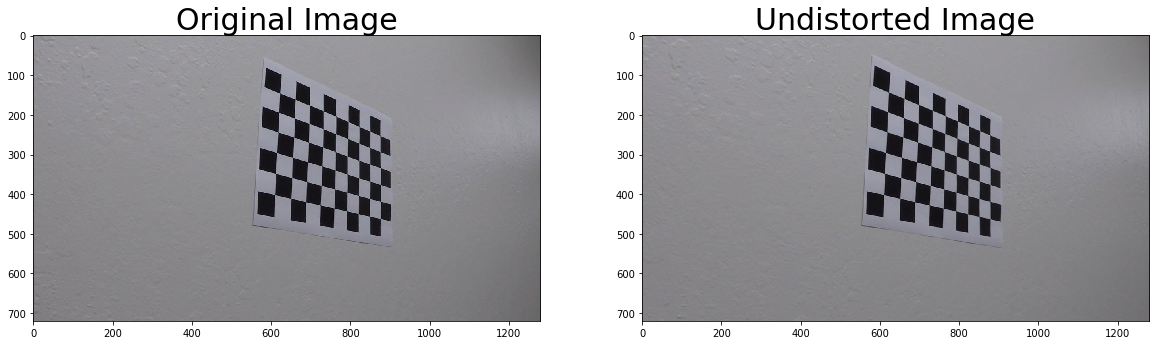

In [3]:
for fname in images:
    
    img=cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2.imread（）方式读取的图片为BGR格式，方便处理这里将BGR转为RGB
    undist = cal_undistort(img, objpoints, imgpoints)   
    cv2.imwrite('output_images/camera_cal/'+fname.split('\\')[-1],undist)

# 可视化
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

Text(0.5, 1.0, 'Undistorted Image')

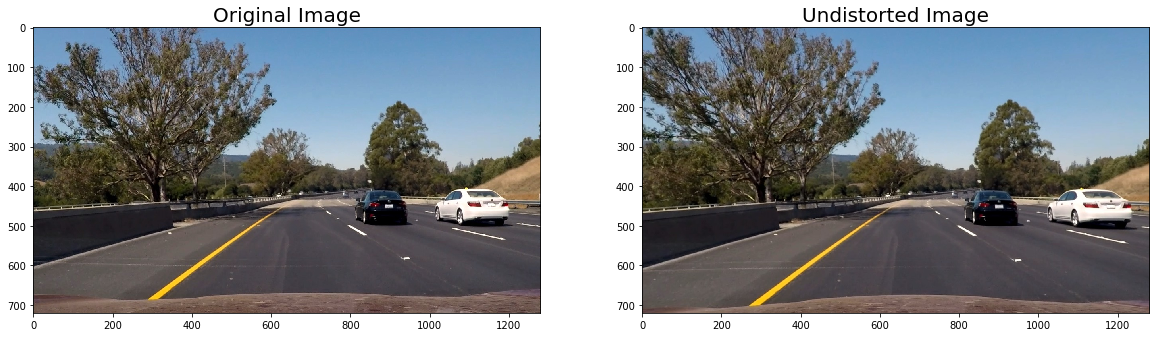

In [4]:
# 获得test_imges文件夹下的图片地址+名字
test_images = glob.glob('test_images/*.jpg')

#创建list存储test_imges文件夹下的图片与校正后的图片
imgs = []     #RGB格式
undist_img=[]

for fname in test_images:  
    img=cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR转为RGB
    imgs.append(img)
    
    undist=cal_undistort(img, objpoints, imgpoints)
    undist_img.append(undist)
    cv2.imwrite('output_images/test_images/'+fname.split('\\')[-1],undist)
    
# 可视化
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=20)

### 第三步:组合色彩与梯度筛选？
组合梯度和色彩过滤车道线像素

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
# 色彩筛选函数
def hls_select(img, l_thresh=(0, 255), s_thresh=(0, 255)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    l_binary = np.zeros_like(S)
    l_binary[(S > l_thresh[0]) & (S <= l_thresh[1])] = 1
    
    hls_binary = np.zeros_like(S)
    hls_binary[(s_binary == 1) | (l_binary == 1)] = 1
    
    return hls_binary

In [7]:
# 索贝尔算子检测边缘函数
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))#图片转换为unit8
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

In [8]:
# 梯度筛选函数
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):     
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 计算x,y方向的梯度
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 对梯度取绝对值
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 用np.arctan2(abs_sobely, abs_sobelx)计算梯度的方向
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 创建一个方向阈值满足要求的二进制掩码
    binary_output =  np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1

    # 返回满足要求的二进制掩码
    return binary_output

In [9]:
# 色彩筛选+边缘检测+梯度筛选
def pipeline(img, sobel_kernel=3, l_thresh=(180, 255),  s_thresh=(170, 255), sx_thresh=(50, 200), dir_thresh=(0, np.pi/2)):

    # 色彩筛选
    hls_binary = hls_select(img, l_thresh=l_thresh, s_thresh=s_thresh)
    # 梯度筛选
    gradx = abs_sobel_thresh(img, sobel_kernel=sobel_kernel,orient='x', thresh=sx_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=sobel_kernel, thresh=dir_thresh)
    # 组合色彩筛选与梯度筛选
    combined = np.zeros_like(hls_binary)
    combined[(gradx == 1) & (dir_binary == 1)| (hls_binary == 1)] = 1
    
    return combined

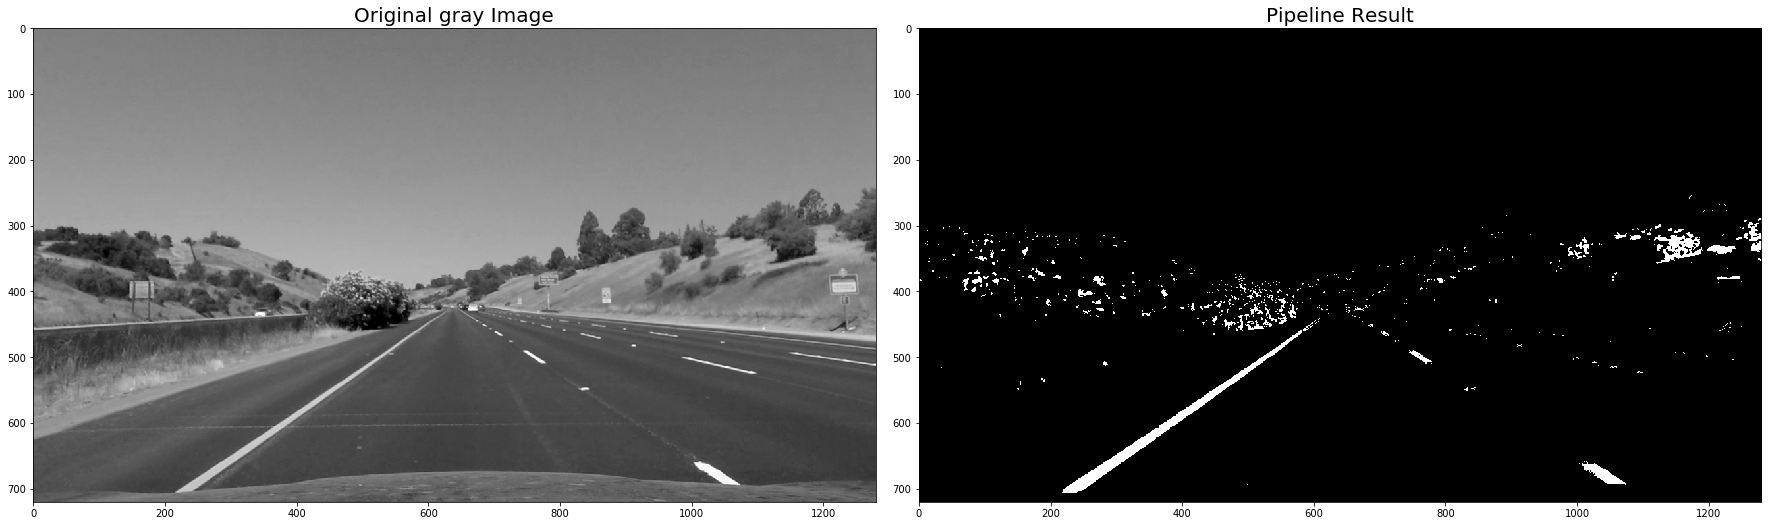

In [10]:
img = undist_img[0]

gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
binary = pipeline(img, sobel_kernel=3, l_thresh=(120, 200),  s_thresh=(170, 255), sx_thresh=(50, 200),dir_thresh=(0.7, 1.3))

# 可视化
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(gray, cmap = 'gray')
ax1.set_title(('Original gray Image'), fontsize=20)

ax2.imshow(binary,cmap = 'gray')
ax2.set_title('Pipeline Result', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 第四步：视角变化，转为俯视视角？？？
应用透视变化技术将二进制图像转换视角得到鸟瞰视角图（"birds-eye view"）

In [11]:
def warp(img, mark = 'warp', offset = 150):
    img_size = (img.shape[1], img.shape[0])
    offset = int(offset)
    
    src_coordinate = [[572,460],[715,460],[1150,720],[150,720]]
    
    src = np.float32(src_coordinate)
    dst = np.float32([[offset, 0], 
              [img_size[0]-offset, 0], 
              [img_size[0]-offset, img_size[1]], 
              [offset, img_size[1]]])

#     wrap_offset = offset
#     src = np.float32([(603, 445), (677, 445), (1105, 720), (205, 720)])
#     dst = np.float32([(205 + wrap_offset, 0), (1105 - wrap_offset, 0), (1105 - wrap_offset, 720), (205 + wrap_offset, 720)])

#     # Source points - defined area of lane line edges
#     src = np.float32([[690,450],[1110,img_size[1]],[175,img_size[1]],[595,450]])

#     # 4 destination points to transfer
#     offset = 300 # offset for dst points
#     dst = np.float32([[img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]],
#                       [offset, img_size[1]],[offset, 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    if mark == 'warp':
        result = cv2.warpPerspective(img, M, img_size)
    if mark == 'unwarp':
        result = cv2.warpPerspective(img, Minv, img_size)
    return result

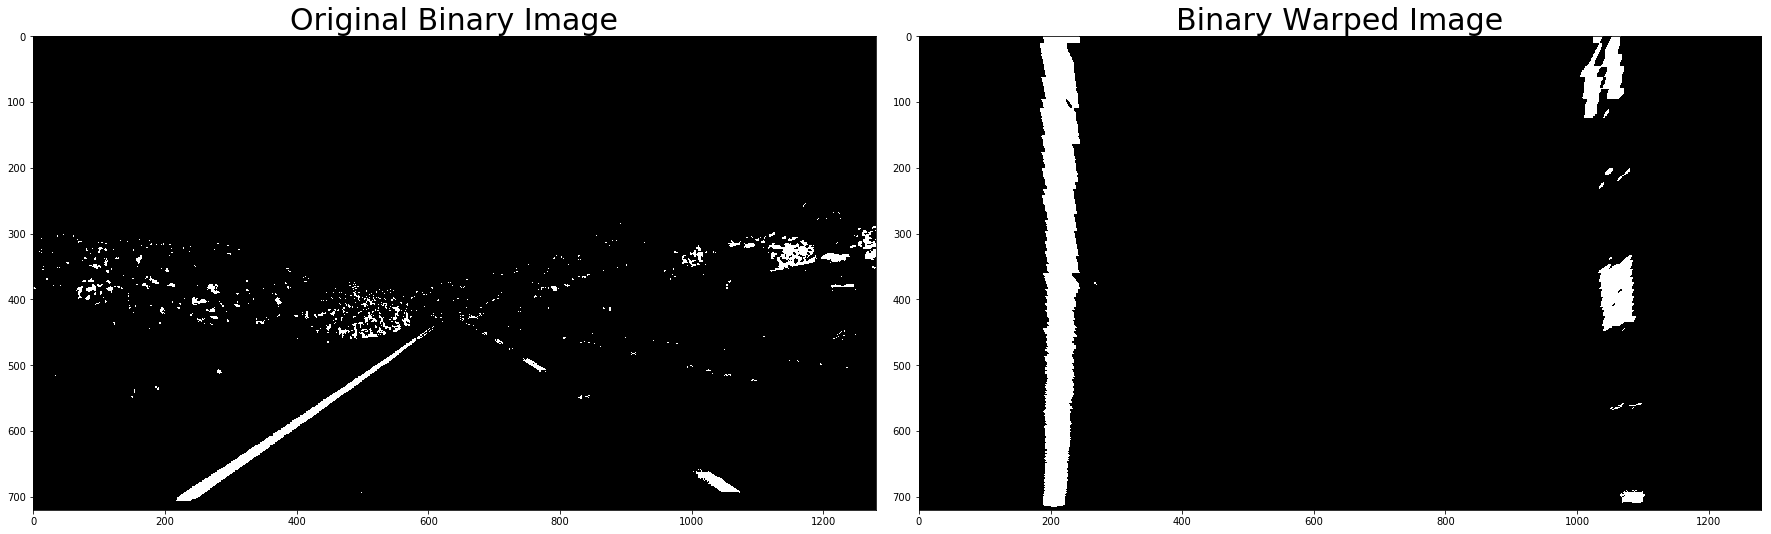

In [12]:
img = binary
binary_warped=warp(img,mark = 'warp', offset = 150)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img, cmap = 'gray')
ax1.set_title(('Original Binary Image'), fontsize=30)

ax2.imshow(binary_warped, cmap = 'gray')
ax2.set_title('Binary Warped Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 第五步：检测车道线

In [13]:
def find_lane_pixels(img):
    
    binary_warped = np.copy(img)
 
    # 对图像下半部分(车道图像主要在图像下半部分)每个坐标上的值在Y方向求和
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
  
    # 创建一个三通道输出图像用来绘制和可视化最终结果
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))   #拼接成三通道
    
    # 找到直方图左右两部分的峰值，峰值点的位置为左右车道的初始位置
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # 定义画的窗口数
    nwindows = 9
    # Set the width of the windows +/- margin。窗口宽度
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # 设置窗口高度：图片宽度/窗口数量
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # 取得图片中所有像素值非零的x，y索引
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #初始当前窗口位置
    leftx_current = leftx_base
    rightx_current = rightx_base

    # 创建空列表来存储左车道和右车道像素索引
    left_lane_inds = []
    right_lane_inds = []

    # 循环遍历每一个窗口
    for window in range(nwindows):
        # 识别窗口边界
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # 识别窗口中的非零像素
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # 将非零像素添加到list中
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # 如果窗口中找到的非零像素个数> minpix，将该窗口位置作为下一个窗口的初始位置
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # 将得到的所有窗口的非零像素list拼接
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    # 把每个框内的非零数据的x,y坐标提取汇总
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


    return leftx, lefty, rightx, righty, out_img

In [14]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):

    # 用np.polyfit()拟合一个二次多项式
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
   
    # 为绘图生成x和y值
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    fit_xy = [left_fitx, right_fitx, ploty]
    fit = [left_fit,right_fit]
    
#     return left_fitx, right_fitx,left_fit,right_fit, ploty
    return fit_xy, fit

In [15]:
def search_around_poly(binary_warped,left_fit,right_fit):
    # 参数设置
    # 选择基于前一个多项式拟合结果的要搜索的边缘宽度
    margin = 100

    # 获取非零像素
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # 在基于前一个多项式拟合结果基础上按照margin宽度搜索非零像素
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # 同样，提取左右线像素位置
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # 拟合多项式
    fit_xy, fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    left_fitx = fit_xy[0]
    right_fitx = fit_xy[1]
    ploty = fit_xy[2]
    left_fit = fit[0]
    right_fit = fit[1]
    
    ## 可视化 ##
    # 创建要绘制的图像和要显示选择窗口的图像
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    # 设置左右车道线像素的颜色
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # 生成一个多边形来演示搜索窗口区域
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # 绘制图形叠加显示
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    left_right_xy = [leftx, lefty, rightx, righty, ploty]
    
    return fit_xy, fit, left_right_xy, result

In [16]:
img_shape=binary_warped.shape
leftx, lefty, rightx, righty, lane_pixels = find_lane_pixels(binary_warped)
fit_xy, fit= fit_poly(img_shape, leftx, lefty, rightx, righty)

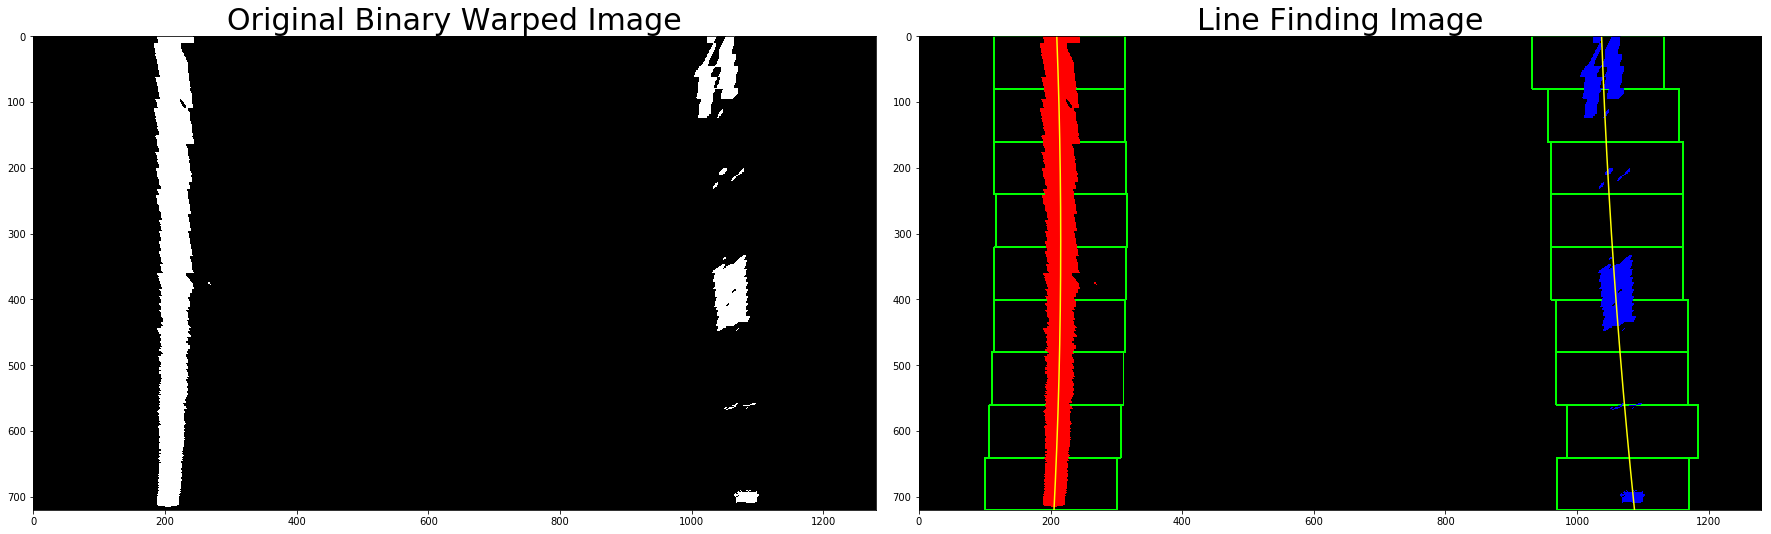

In [17]:
# 通过find_lane_pixels（）函数的得到的车道像素结果可视化
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary_warped, cmap = 'gray')
ax1.set_title(('Original Binary Warped Image'), fontsize=30)

ax2.imshow(lane_pixels)
ax2.plot(fit_xy[0], fit_xy[2], color='yellow')
ax2.plot(fit_xy[1], fit_xy[2], color='yellow')
ax2.set_title('Line Finding Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

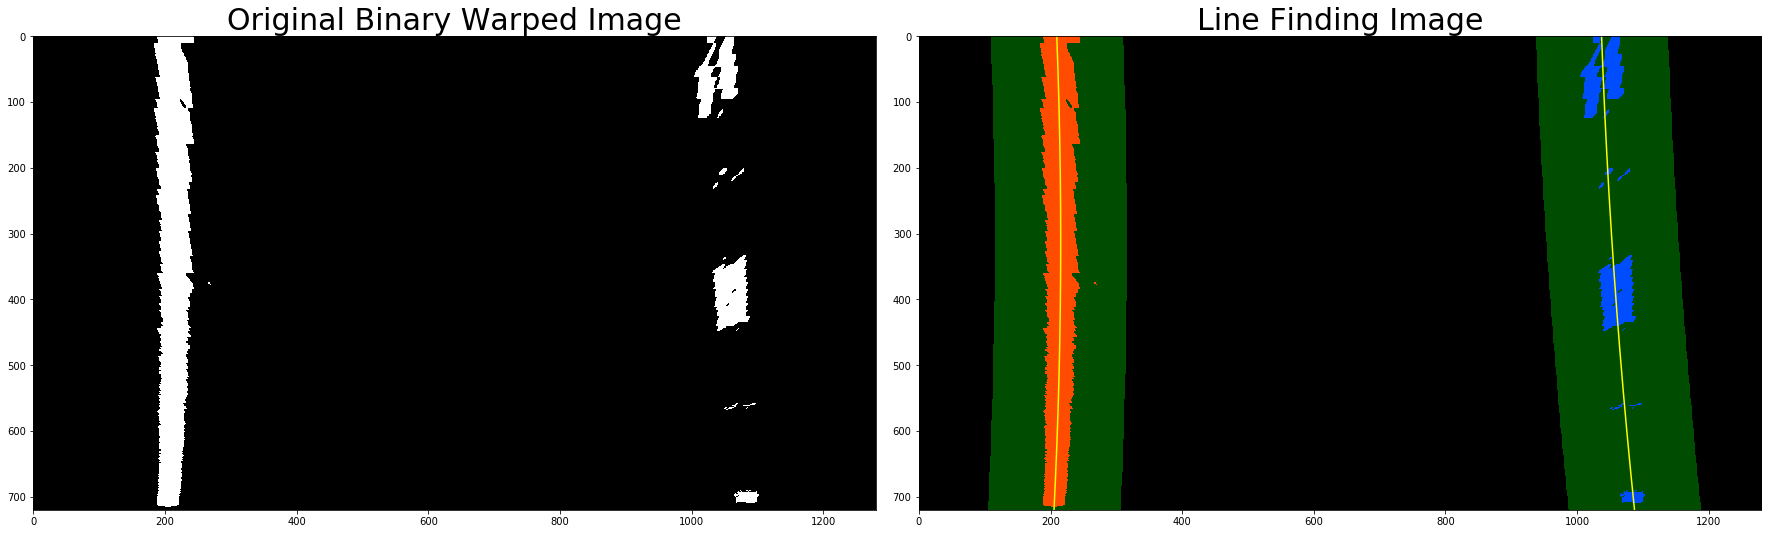

In [18]:

# 在find_lane_pixels（）函数的得到的车道像素拟合出来的二次曲线基础上检测车道像素
fit_xy, fit, left_right_xy, result = search_around_poly(binary_warped,fit[0],fit[1])

# 结果可视化
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary_warped, cmap = 'gray')
ax1.set_title(('Original Binary Warped Image'), fontsize=30)

ax2.imshow(result,cmap = 'gray')
ax2.plot(fit_xy[0], fit_xy[2], color='yellow')
ax2.plot(fit_xy[1], fit_xy[2], color='yellow')
ax2.set_title('Line Finding Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 第六步:计算曲率半径

In [19]:
def measure_curvature_real(leftx, lefty, rightx, righty, ploty):
    '''
    计算检测到的车道线的曲率半径
    '''
    # 定义从像素到米的单位转换
    ym_per_pix = 30/720 # y方向（30/720）米/像素
    xm_per_pix = 3.7/700 # x方向（3.7/700）米/像素

    # 将检测到的车道线像素转换为米为单位
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    y_eval = np.max(ploty)
    
    # 计算曲率半径
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [20]:
# Calculate the radius of curvature in meters for both lane lines
leftx = left_right_xy[0]
lefty = left_right_xy[1]
rightx = left_right_xy[2]
righty = left_right_xy[3]
ploty = left_right_xy[4]

left_curverad, right_curverad = measure_curvature_real(leftx, lefty, rightx, righty, ploty)

print('左侧车道曲率半径为：{}米'.format(left_curverad))
print('右侧车道曲率半径为：{}米'.format(right_curverad))

左侧车道曲率半径为：2675.6975756876445米
右侧车道曲率半径为：3514.56489685919米


### 结果显示

In [27]:
def out_put(img, left_fitx, right_fitx, ploty, binary_warped, left_curverad, right_curverad):
    """
    将程序得到的车道线结果与原图叠加显示
    """
    # 创建一个空白图像用于绘制车道
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # 将x和y点重新转换为cv2.fillPoly()的可用格式
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # 在创建的空白图像上绘制车道（鸟瞰图）
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # 将车道（鸟瞰图）unwarp回摄像头视角
    unwarp = warp(color_warp, mark = 'unwarp', offset = 150)

    # 将绘制的车道与原图叠加显示
    result = cv2.addWeighted(img, 1, unwarp, 0.2, 0)
    
    # 将曲率半径显示在图上
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Radius of  left curvature: %.1f(m)' %left_curverad ,(60,90), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result, 'Radius of right curvature: %.1f(m)' %right_curverad,(60,130), font, 1,(255,255,255),2,cv2.LINE_AA)  
    
    return result


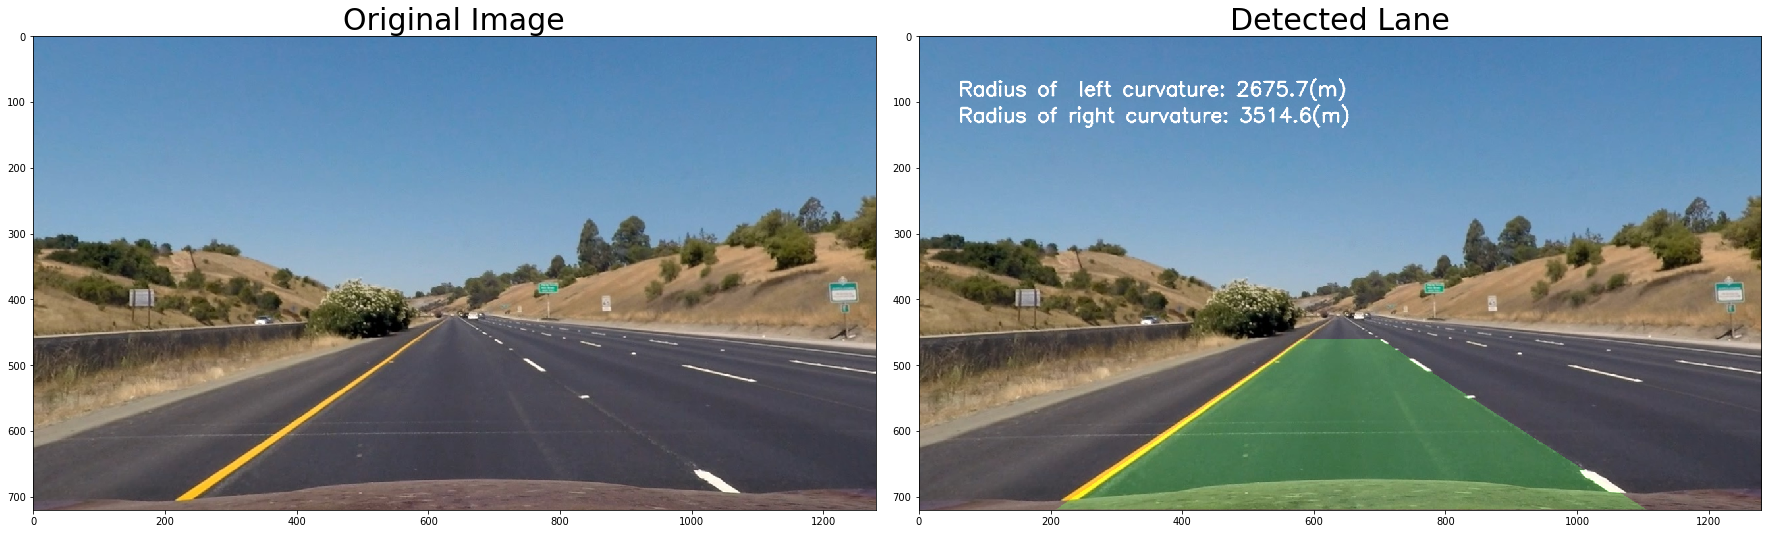

In [28]:
all_result = out_put(undist_img[0],fit_xy[0], fit_xy[1], fit_xy[2], binary_warped, left_curverad, right_curverad)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist_img[0])
ax1.set_title(('Original Image'), fontsize=30)

ax2.imshow(all_result)
ax2.set_title('Detected Lane', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 视频

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [30]:
def process_image(image):
    
    # -------------------------------------------------------------
    # 1.计算摄像机的校准矩阵与畸变系数
    # ------------------------------------------------------------- 
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # 创建空list用于存储来自所有图像的实际点和图像点
    objpoints = [] # 3D点称为object points，真实世界的坐标
    imgpoints = [] # 2D图像点称为image points

    # 得到camera_cal文件夹下图片的路径+文件名，存储到list
    images = glob.glob('camera_cal/calibration*.jpg')

    # 对camera_cal文件夹下图片逐个处理得到corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # 找到棋盘的corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        #如果找到corners,将实际点和图像点添加到list中
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    # -------------------------------------------------------------
    # 2.图像失真矫正
    # -------------------------------------------------------------  
    undist_end = cal_undistort(image, objpoints, imgpoints)
    
    # -------------------------------------------------------------
    # 3.对图像进行组合色彩与梯度筛选
    # -------------------------------------------------------------     
    binary_end = pipeline(undist_end, 
                          sobel_kernel=3, 
                          l_thresh=(120, 200),  
                          s_thresh=(170, 255), 
                          sx_thresh=(50, 200),
                          dir_thresh=(0.7, 1.3))

    # -------------------------------------------------------------
    # 4.视角转换
    # -------------------------------------------------------------
    
    binary_warp=warp(binary_end, mark = 'warp', offset = 150)

    # -------------------------------------------------------------
    # 5.检测车道线
    # -------------------------------------------------------------
    if process_image.first == True:
        leftx, lefty, rightx, righty, lane_pixels = find_lane_pixels(binary_warp)
        
        fit_xy, fit = fit_poly(binary_warp.shape, leftx, lefty, rightx, righty)
        ploty = fit_xy[2]
        
        process_image.left_fit = fit[0]
        process_image.right_fit = fit[1]
        process_image.first = False
        
    else:

        fit_xy, fit, left_right_xy, line = search_around_poly(binary_warp, process_image.left_fit, process_image.right_fit)
        process_image.left_fit = fit[0]
        process_image.right_fit = fit[1]
        
        leftx = left_right_xy[0]
        lefty = left_right_xy[1]
        rightx = left_right_xy[2]
        righty = left_right_xy[3]
        ploty = left_right_xy[4]
        
    # -------------------------------------------------------------
    # 6.计算曲率半径
    # -------------------------------------------------------------

    left_curverad, right_curverad = measure_curvature_real(leftx, lefty, rightx, righty, ploty)
    
    # -------------------------------------------------------------
    # 7.结果叠加显示
    # -------------------------------------------------------------                                                           
    result_out = out_put(undist_end, fit_xy[0], fit_xy[1], fit_xy[2], binary_warp, left_curverad, right_curverad)
    plt.imshow(result_out)
    
    
    return result_out

process_image.left_fit = None
process_image.right_fit = None
process_image.first = True


Moviepy - Building video lane_finding_output_video.mp4.


Moviepy - Writing video lane_finding_output_video.mp4



t:  11%|███████                                                           | 135/1260 [01:51<15:24,  1.22it/s, now=None]


t:  22%|██████████████▏                                                   | 271/1260 [03:43<13:25,  1.23it/s, now=None]


t:  32%|█████████████████████▎                                            | 407/1260 [05:35<11:41,  1.22it/s, now=None]


t:  43%|████████████████████████████▍                                     | 543/1260 [07:27<09:49,  1.22it/s, now=None]


t:  54%|███████████████████████████████████▌                              | 679/1260 [09:20<07:54,  1.22it/s, now=None]


t:  65%|██████████████████████████████████████████▋                       | 815/1260 [11:12<06:07,  1.21it/s, now=None]


t:  75%|█████████████████████████████████████████████████▊                | 951/1260 [13:05<04:16,  1.20it/s, now=None]


t:  86%|████████████████████████████████████████████████████████         | 1087/1260 [14:59<02:23,  1.20it/s, now=None]


t:  97%|███████████████████████████████████████████████████████████████  | 1223/1260 [16:52<00:30,  1.20it/s, now=None]


t: 100%|█████████████████████████████████████████████████████████████████| 1260/1260 [17:23<00:00,  1.21it/s, now=None]


Moviepy - Done !


Moviepy - video ready lane_finding_output_video.mp4


t:   5%|███▍                                                               | 65/1260 [19:11<16:17,  1.22it/s, now=None]

Wall time: 17min 25s


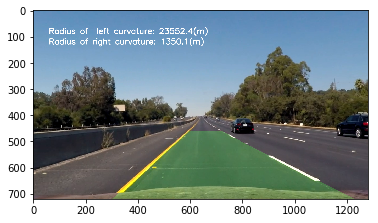

In [31]:
white_output = 'lane_finding_output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))